## Домашнее задание №3

#### Горская Елена

Задача решалась в постановке, когда для каждой точки задан выбор из двух вариантов расположения подписи. 

Какой формат входных данных (частично совпадает с тем, что обсуждалось в чате):

(координаты точки) < space > (размер рамки) < space > (первый вариант расположения левого нижнего угла рамки) < space > (второй вариант расположения левого нижнего угла рамки).

Например:

$x,y$ $\quad$ $w,h$ $\quad$ $x_1,y_1$ $\quad$ $x_2,y_2$

Здесь:
* $(x,y)$ - координаты точки
* $w$ - ширина рамки
* $h$ - высота рамки
* $(x_1,y_1)$ - первый вариант расположения левого нижнего угла рамки
* $(x_2,y_2)$ - второй вариант расположения левого нижнего угла рамки

In [ ]:
# библиотеки
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from matplotlib.patches import Rectangle

В ячейку ниже можно ввести данные в указанном формате.

In [ ]:
raw_data = '''
10,10 10,10 0,0 10,10
15,15 10,15 5,0 15,15
20,40 16,8 12,32 12,40
21,10 15,10 6,10 21,0
40,40 5,5 40,40 35,35
8,40 6,6 5,37 8,40
15,35 4,4 13,33 15,35
43,43 10,10 33,38 43,38
40,14 12,6 34,8 34,14
'''

Обработка данных:

In [ ]:
point_positions = []
box_sizes = []
box_positions_1 = []
box_positions_2 = []

cur_lines = raw_data.strip().split('\n')

for line in cur_lines:
  arr = line.split(' ')
  point_positions.append(np.array(arr[0].split(','), dtype=int))
  box_sizes.append(np.array(arr[1].split(','), dtype=int))
  box_positions_1.append(np.array(arr[2].split(','), dtype=int))
  box_positions_2.append(np.array(arr[3].split(','), dtype=int))

Сам алгоритм, разбитый на функции:

In [ ]:
# пересекаются ли два прямоугольника
def do_boxes_intersect(pos_1, size_1, pos_2, size_2):
  # top-right-x-1 < bottom-left-x-2
  if (pos_1[0] + size_1[0] < pos_2[0]):
    return False

  # bottom-left-x-1 > top-right-x-2
  if (pos_1[0] > pos_2[0] + size_2[0]):
    return False
  
  # top-right-y-1 < bottom-left-y-2
  if (pos_1[1] + size_1[1] < pos_2[1]):
    return False

  # bottom-left-y-1 > top-right-y-2
  if (pos_1[1] > pos_2[1] + size_2[1]):
    return False

  return True


# ищем пары:
# для первого положения прямоугольника номер тот же
# для второго - к номеру прибавляется n (общее число точек)
def find_pairs(point_positions, box_sizes, box_positions_1, box_positions_2):
  res = []
  n = len(point_positions)
  for i in range(len(point_positions) - 1):
    for j in range(i + 1, len(point_positions)):
      point_1 = point_positions[i]
      point_2 = point_positions[j]
      if do_boxes_intersect(box_positions_1[i], 
                            box_sizes[i], 
                            box_positions_1[j], 
                            box_sizes[j]):
        res.append([i, j])

      if do_boxes_intersect(box_positions_1[i], 
                            box_sizes[i], 
                            box_positions_2[j], 
                            box_sizes[j]):
        res.append([i, j + n])
      
      if do_boxes_intersect(box_positions_2[i], 
                            box_sizes[i], 
                            box_positions_1[j], 
                            box_sizes[j]):
        res.append([j, i + n])

      if do_boxes_intersect(box_positions_2[i], 
                            box_sizes[i], 
                            box_positions_2[j], 
                            box_sizes[j]):
        res.append([i + n, j + n])

  for i in range(len(point_positions)):
    # если вылезли за 500
    if (box_positions_1[i][0] + box_sizes[i][0] > 500) or (box_positions_1[i][1] + box_sizes[i][1] > 500): 
      res.append([i, i + 1])
      res.append([i, find_co_pair(i + 1, n)])
    if (box_positions_2[i][0] + box_sizes[i][0] > 500) or (box_positions_2[i][1] + box_sizes[i][1] > 500): 
      res.append([i + n, i + 1])
      res.append([i + n, find_co_pair(i + 1, n)])

  return res


# номер противоположной вершины (в SAT-понимании)
def find_co_pair(x, n):
  if (x < n):
    return n + x
  else:
    return x - n


# создание графа из списка пар
def make_graph(pairs, n):
  nodes = list(np.arange(2 * n))
  edges = []
  for i in range(len(nodes)):
    edges.append([])
  for pair in pairs:
    edges[pair[0]].append(find_co_pair(pair[1], n))
    edges[pair[1]].append(find_co_pair(pair[0], n))
  return nodes, edges


# здесь использовался алгоритм Тарьяна для поиска сильных компонент
def find_components(nodes, edges):
  index = 0
  n = len(nodes)
  stack = []
  lowlinks = np.full_like(nodes, 2 * n + 1)
  indices = np.full_like(nodes, 2 * n + 1)
  comps = []

  def connect_strong(v):
    nonlocal index
    lowlinks[v] = index
    indices[v] = index
    index += 1
    stack.append(v)

    for u in edges[v]:
      if lowlinks[u] == 2 * n + 1:
        connect_strong(u)
        lowlinks[v] = min(lowlinks[v], lowlinks[u])
      else:
        if u in stack:
          lowlinks[v] = min(lowlinks[v], indices[u])
        else:
          continue

    if lowlinks[v] == indices[v]:
      # start a new component
      comp = []
      while True:
        u = stack.pop()
        comp.append(u)
        if u == v:
          break
      comps.append(comp)

  for v in nodes:
    if lowlinks[v] == 2 * n + 1:
      connect_strong(v)
  return comps


# поиск решения 2-SAT
def solve_2_sat(nodes, edges):
  components = find_components(nodes, edges)
  results = np.full_like(nodes, -1)
  n = len(nodes)
  for comp in components:
    for node in comp:
      if find_co_pair(node, int(n / 2)) in comp:
        return False, -1
      if results[node] == -1:
        results[node] = 1
        results[find_co_pair(node, int(n / 2))] = 0
  return True, results


# основной алгоритм: поиск местоположений подписей
def find_labels(point_positions, box_sizes, box_positions_1, box_positions_2):
  contradict_pairs = find_pairs(point_positions, box_sizes, 
                                box_positions_1, box_positions_2)
  n = len(point_positions)
  nodes, edges = make_graph(contradict_pairs, n)
  success, res = solve_2_sat(nodes, edges)
  if not success:
    print('Solution does not exist for this task')
    return -1
  else:
    output = []
    for i in range(int(len(res) / 2)):
      if res[i] == 0:
        output.append(box_positions_2[i])
      else:
        output.append(box_positions_1[i])
    return output

In [ ]:
res_positions = find_labels(point_positions, box_sizes, box_positions_1, box_positions_2)

Можно посмотреть на координаты выбранных позиций:

In [ ]:
res_positions

[array([0, 0]),
 array([15, 15]),
 array([12, 40]),
 array([21,  0]),
 array([35, 35]),
 array([ 5, 37]),
 array([15, 35]),
 array([43, 38]),
 array([34, 14])]

Рисуем то, что получилось

In [ ]:
points_x = []
points_y = []
for p in point_positions:
  points_x.append(p[0])
  points_y.append(p[1])

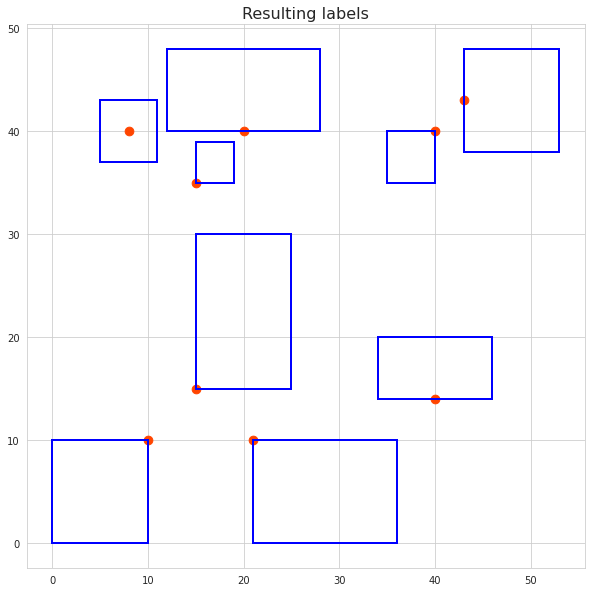

In [ ]:
sns.set_style("whitegrid")

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.scatter(points_x, points_y, c='orangered', marker='o', s=75)

for i in range(len(point_positions)):
  ax.add_patch(Rectangle((res_positions[i][0], res_positions[i][1]), 
                         box_sizes[i][0], box_sizes[i][1], 
                         edgecolor = 'blue', fill=False, lw=2))

plt.title("Resulting labels", fontsize=16)
plt.show()

Как видим, прямоугольники не пересекаются. И, в целом, картинка выглядит неплохо.

Тут я рисую не от 0 до 500, а меньше, чтобы было хорошо видно. Но условие про то, что за холст (500, 500) вылезать не должны, учитывается (в конце есть пример).

А теперь попробуем задать невозможную ситуацию (т.е. когда решения не существует). В заданных ниже значениях нельзя нарисовать подписи без пересечения.

In [ ]:
raw_data_2 = '''
10,10 10,10 0,0 10,10
15,15 10,15 5,0 15,15
21,10 15,10 6,10 6,0
'''

In [ ]:
new_point_positions = []
new_box_sizes = []
new_box_positions_1 = []
new_box_positions_2 = []

new_cur_lines = raw_data_2.strip().split('\n')

for line in new_cur_lines:
  arr = line.split(' ')
  new_point_positions.append(np.array(arr[0].split(','), dtype=int))
  new_box_sizes.append(np.array(arr[1].split(','), dtype=int))
  new_box_positions_1.append(np.array(arr[2].split(','), dtype=int))
  new_box_positions_2.append(np.array(arr[3].split(','), dtype=int))

In [ ]:
res_positions_2 = find_labels(new_point_positions, new_box_sizes, new_box_positions_1, new_box_positions_2)

Solution does not exist for this task


И снова алгоритм сработал верно: вывелась строчка о том, что решения не существует.

И вот что будет, если вылезем за холст (500, 500):

In [ ]:
raw_data_3 = '''
10,10 10,10 0,0 10,10
495,495 10,10 495,495 485,495
'''

In [ ]:
new_point_positions_3 = []
new_box_sizes_3 = []
new_box_positions_1_3 = []
new_box_positions_2_3 = []

new_cur_lines_3 = raw_data_3.strip().split('\n')

for line in new_cur_lines_3:
  arr = line.split(' ')
  new_point_positions_3.append(np.array(arr[0].split(','), dtype=int))
  new_box_sizes_3.append(np.array(arr[1].split(','), dtype=int))
  new_box_positions_1_3.append(np.array(arr[2].split(','), dtype=int))
  new_box_positions_2_3.append(np.array(arr[3].split(','), dtype=int))

In [ ]:
res_positions_3 = find_labels(new_point_positions_3, new_box_sizes_3, new_box_positions_1_3, new_box_positions_2_3)

Solution does not exist for this task


То есть за пределы холста также не можем выходить.